In this notebook we will explore model explainability of transformer models trained on text data by using one of the most advanced explainability method called `SHAP`(https://github.com/shap/shap)

# Installing the modules

In [157]:
!pip install --upgrade numpy shap transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 50.0 MB/s eta 0:00:0031m53.6 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 50.0 MB/s eta 0:00:0031m52.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 48.1 MB/s eta 0:00:0031m51.2 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.1
    Uninstalling numpy-2.2.1:
      Successfully uninstalled numpy-2.2.1


# Loading Libraries

In [245]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from typing import Tuple, Dict
np.random.seed(123)

import shap
print(f"Shap version used: {shap.__version__}")
import transformers
print(f"Hugging Face transformer version used: {transformers.__version__}")
from transformers import AutoModelForSequenceClassification, AutoTokenizer, ZeroShotClassificationPipeline,AutoModelForCausalLM, Pipeline
from typing import Union, List

Shap version used: 0.46.0
Hugging Face transformer version used: 4.48.0


# Explaining transformer based Text Classification models

In [174]:
# Loading the transformers pipeline model for text classification
model = transformers.pipeline('text-classification', return_all_scores=True)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


In [175]:
# Loading the text data
text_data = "Shap makes great job for explaining the most complex models"

In [176]:
model(text_data)[0]

[{'label': 'NEGATIVE', 'score': 0.0008332918514497578},
 {'label': 'POSITIVE', 'score': 0.99916672706604}]

So, we can see that the model predicted the outcome to be positive with a very high confidence score, which is correct! Now, let's see if this can be explained using SHAP.

In [177]:
# Defining SHAP explainer object
explainer = shap.Explainer(model) 
shap_values = explainer([text_data])

In [178]:
shap.plots.text(shap_values[0,:,'POSITIVE'])

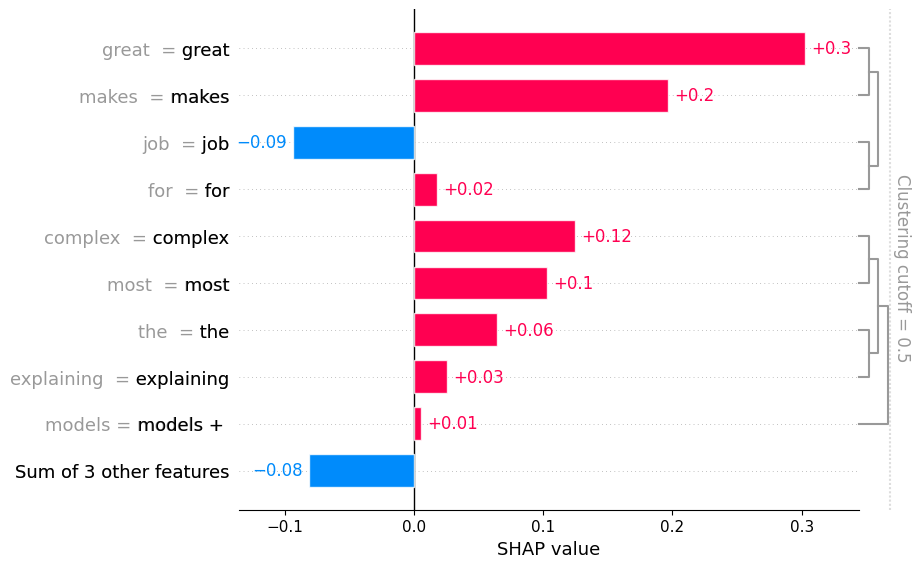

In [180]:
shap.plots.bar(shap_values[0,:,'POSITIVE'])

# Explaining Multi-Class prediction transformer models using SHAP

In [262]:
# Load FinBERT model and tokenizer
model_name = "ProsusAI/finbert"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [263]:
# build a pipeline object to do predictions
pipeline = transformers.pipeline("text-classification", model=model, tokenizer=tokenizer, device=0, return_all_scores=True)

Device set to use mps:0


# Understanding Partition Explainer

As we will use Partition Explainer in for our multi-class case. Let's dig into it a bit with a basic example

In [287]:
example_text = ["I love sci-fi and eat a lot. you?"]
shap_values_test = explainer(example_text)

In [288]:
shap_values_test.feature_names[0]

['',
 'I',
 'love',
 'sci',
 '-',
 'fi',
 'and',
 'eat',
 'a',
 'lot',
 '.',
 'you',
 '?',
 '']

Partition explainer creates a hierarchical structure that it uses for the shap calculation.

In [289]:
cluster_matrix = shap_values_test.clustering
labels = list(shap_values_test.feature_names[0])

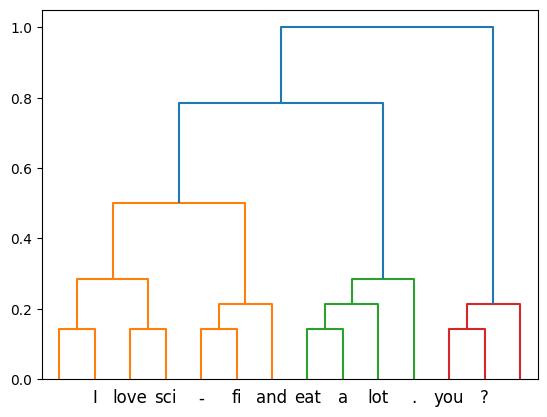

In [292]:
from scipy.cluster import hierarchy
hierarchy.dendrogram(cluster_matrix[0],labels=list(labels));

As the model trained on financial text we will provide financial texts that consisting of positive,negative and neutral class for and will be analyzing explanations

In [267]:
text = ['The company posted record profits this quarter, signaling a remarkable achievement in its financial performance.',
 'The market is uncertain, with investors facing challenges in predicting future trends and outcomes.',
 'The stock price plummeted, reflecting a significant downturn in market sentiment.']

In [268]:
# Initialize the SHAP explainer
explainer = shap.Explainer(pipeline)

text = [
    'The company posted record profits this quarter, signaling a remarkable achievement in its financial performance.',
    'The market is uncertain, with investors facing challenges in predicting future trends and outcomes.',
    'The stock price plummeted, reflecting a significant downturn in market sentiment.'
]

# Generate SHAP values for the entire text array
shap_values = explainer(text)

# Visualize SHAP explanations for each text sample
for i, value in enumerate(shap_values):
    print(f"Explanation for text {i + 1}:\n{text[i]}")
    shap.plots.text(value)

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [00:14,  7.49s/it]                                              

Explanation for text 1:
The company posted record profits this quarter, signaling a remarkable achievement in its financial performance.


Explanation for text 2:
The market is uncertain, with investors facing challenges in predicting future trends and outcomes.


Explanation for text 3:
The stock price plummeted, reflecting a significant downturn in market sentiment.


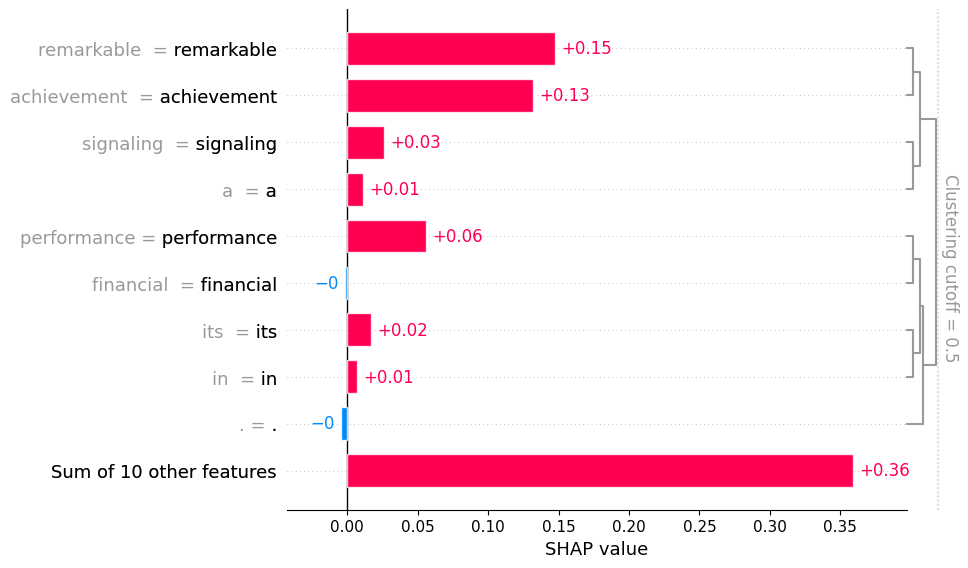

In [300]:
# Top Features
shap.plots.bar(shap_values[0,:,'positive'])

We can also aggregate the explanations to see what words show up the most across all the explanations.

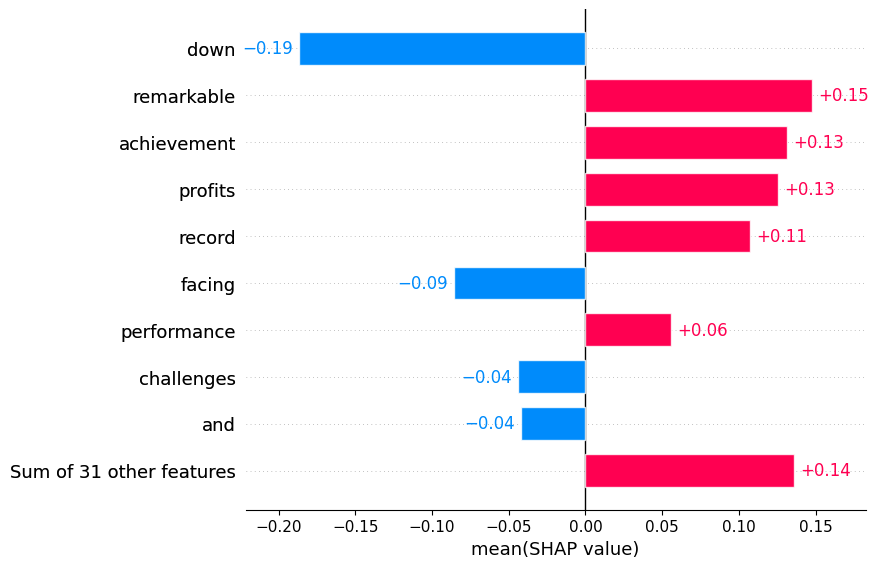

In [304]:
shap.plots.bar(shap_values[:, :, "positive"].mean(0),max_display=10)